# Week 9 - Anomaly Detection and Recommender Systems

In this exercise, we will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies.

## Anomaly Detection

In this exercise, we will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While our servers were operating, we collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset. We suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

We will use a Gaussian model to detect anomalous examples in your dataset. We will first start on a 2D dataset that will allow us to visualize what the algorithm is doing. On that dataset we will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, we will apply the anomaly detection algorithm to a larger dataset with many dimensions.

### Visualizing the Data

Let's first load the data and see how it looks.

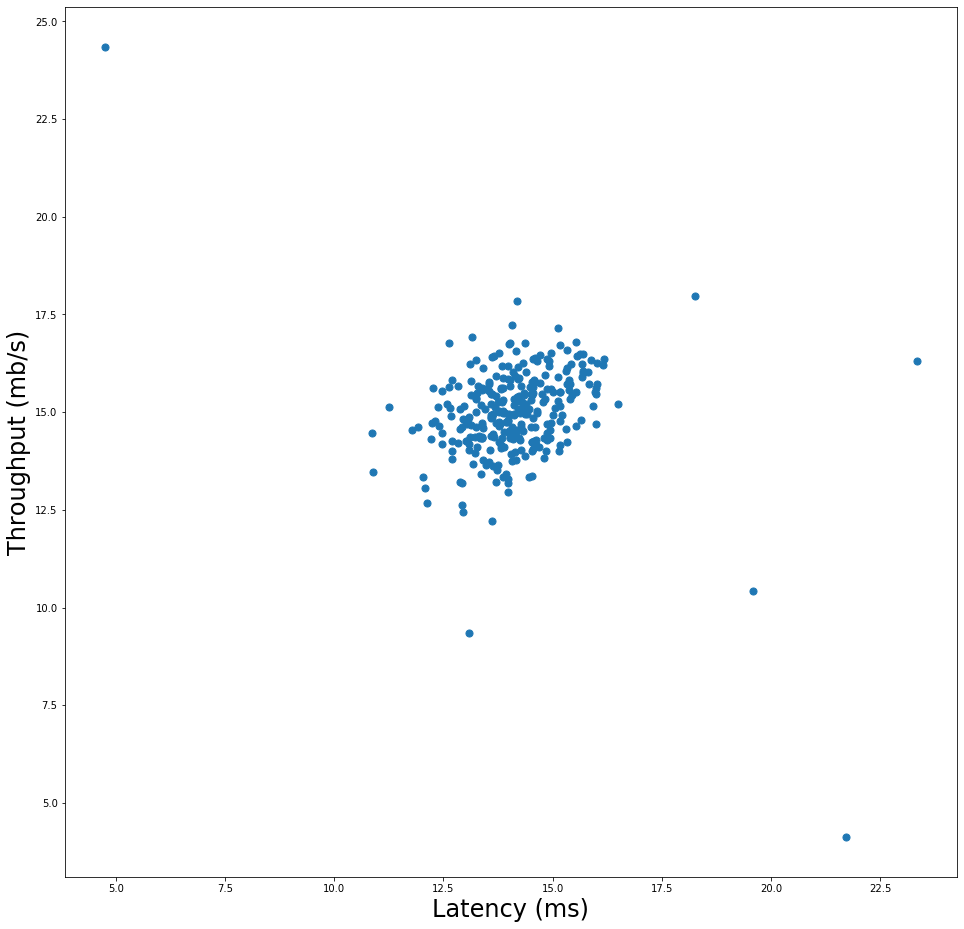

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import stats
from scipy import optimize

# Set the data path
dataDir = "./assignment/ex8/"
dataFile = "ex8data1.mat"
dataPath = dataDir+dataFile

# Load the data
data = loadmat(dataPath)
X = data['X']
XVal = data['Xval']
yVal = data['yval'].flatten()

# Plot the data
fig, ax = plt.subplots(figsize=(16,16));
ax.scatter(X[:,0],X[:,1], s=50, marker='o');
ax.set_xlabel('Latency (ms)', fontsize=24);
ax.set_ylabel('Throughput (mb/s)', fontsize=24);

So we can see here a somewhat Gaussian distribution with some anomalous activity. So now let's find a way to identify those anomalies.

### Gaussian Distribution

Recall that the Gaussian distribution is given by

$$ p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \big( - \frac{(x-\mu)^2}{2 \sigma^2} \big) $$

where 
* $\mu$ is the mean
* $\sigma$ is the standard deviation

So let's first create a function that finds the mean and standard deviation of an array.

In [2]:
def mean_and_var(X):
    
    """Find the mean and variance of an array"""
    
    # Get the parameters with the numpy functions for the array class
    mu =  X.mean(axis=0)
    sigma2 = X.var(axis=0)
    
    return mu,sigma2

These are our model parameters, so now we need a function to calculate the Gaussian distribution. We'll use the multivariate  Gaussian distribution formulation here.

In [3]:
def gaussian_distribution(X,mu,Sigma2):
    
    """Use the mean and variance to get the Gaussian distribution associated with a dataset"""
    
    # Get the number of features
    k = mu.size
    
    # If sigma is given as a diagonal, compute the matrix
    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)

    # Mean normalize the X array
    X = X - mu
    
    # Calculate the MVGD PDF
    p = (2*np.pi)**(-k/2)*np.linalg.det(Sigma2)**(-0.5)*\
        np.exp(-0.5*np.sum(np.dot(X,np.linalg.pinv(Sigma2))*X,axis=1))
    
    # Return probability matrix
    return p

Lastly, we need to create a function that will find the optimal threshold for our anomoly probability cut-off. We'll calculate an F1-score for various choices, and pick the best threshold compared to the cross-validation set.

In [4]:
def select_threshold(pVal,yVal):
    
    """Loop through various options for thresholds and find the best one"""
    
    # Initialize some variables
    bestEpsilon = 0.0
    bestF1 = 0.0
    F1 = 0.0
    
    # Loop through our range of probabilities
    for epsilon in np.arange(pVal.min(),pVal.max(),(pVal.max()-pVal.min())/1000.):
                
        # Get the predictions for this epsilon
        predictions = (pVal <= epsilon)
        
        # Get the true/false positives/negatives
        tp = np.sum(np.logical_and(predictions==1,yVal==1))
        fp = np.sum(np.logical_and(predictions==1,yVal==0))
        fn = np.sum(np.logical_and(predictions==0,yVal==1))
                
        # Get the precision and recall
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
    
        # Get the F1 score
        F1 = (2.*precision*recall)/(precision+recall)
        #print(tp,fp,fn)
        
        # If we have a better F1 score, update epsilon
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
     
    # Return the best options
    return bestEpsilon, bestF1

### Visualizing the Results

Now let's see how our anomaly prediction performed.

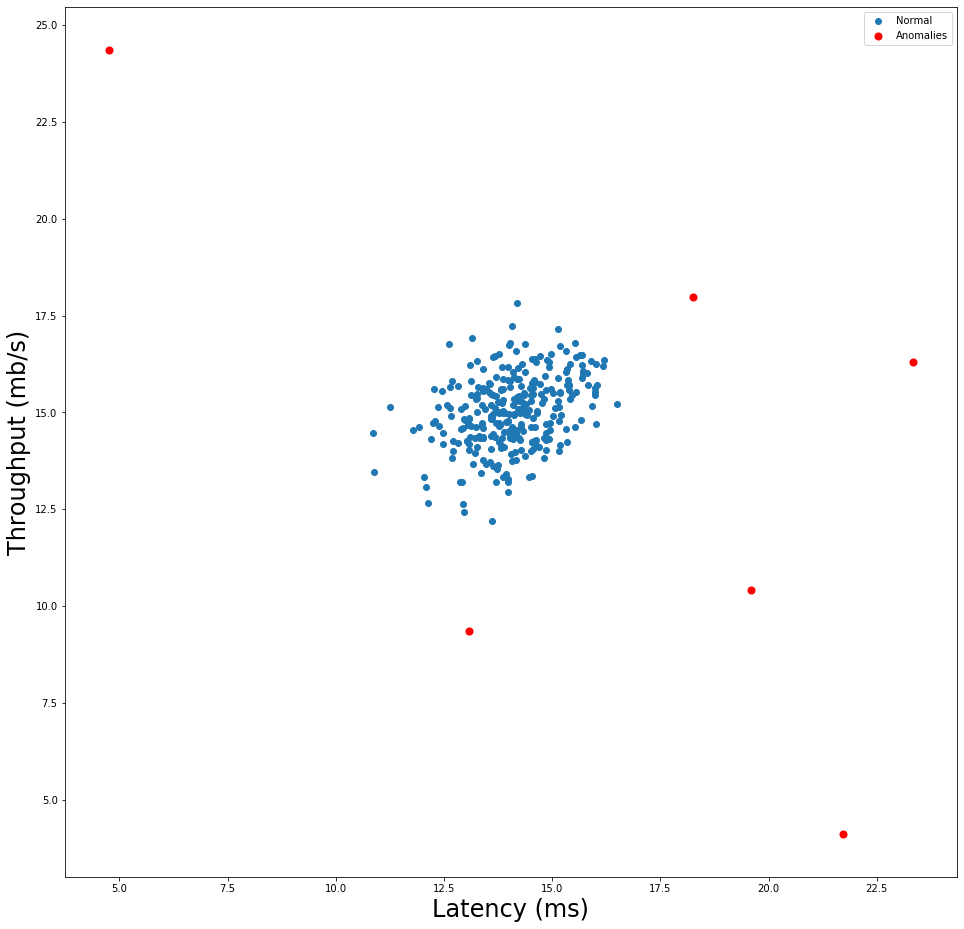

In [5]:
# Get the Gaussian distribution and ideal threshold
mu,sigma2 = mean_and_var(X)
p = gaussian_distribution(X,mu,sigma2)
pVal = gaussian_distribution(XVal,mu,sigma2)
epsilon,F1 = select_threshold(pVal,yVal)

# Indexes of the values considered to be outlibers
outliers = np.where(p < epsilon)

# Create plot
fig, ax = plt.subplots(figsize=(16,16));
ax.scatter(X[:,0], X[:,1],label="Normal");
ax.scatter(X[outliers[0],0],X[outliers[0],1],s=50,color='r',label="Anomalies");
ax.set_xlabel('Latency (ms)', fontsize=24);
ax.set_ylabel('Throughput (mb/s)', fontsize=24);
ax.legend();

And we see here it did a great job of selecting data points outside of the main cluster. These clearly look like anomalies! 

Let's check out one more case for a more realistic and difficult dataset. This time, we'll have 11 features and more datapoints. We'll run the same procedure and show a 2D plot of the first two features.

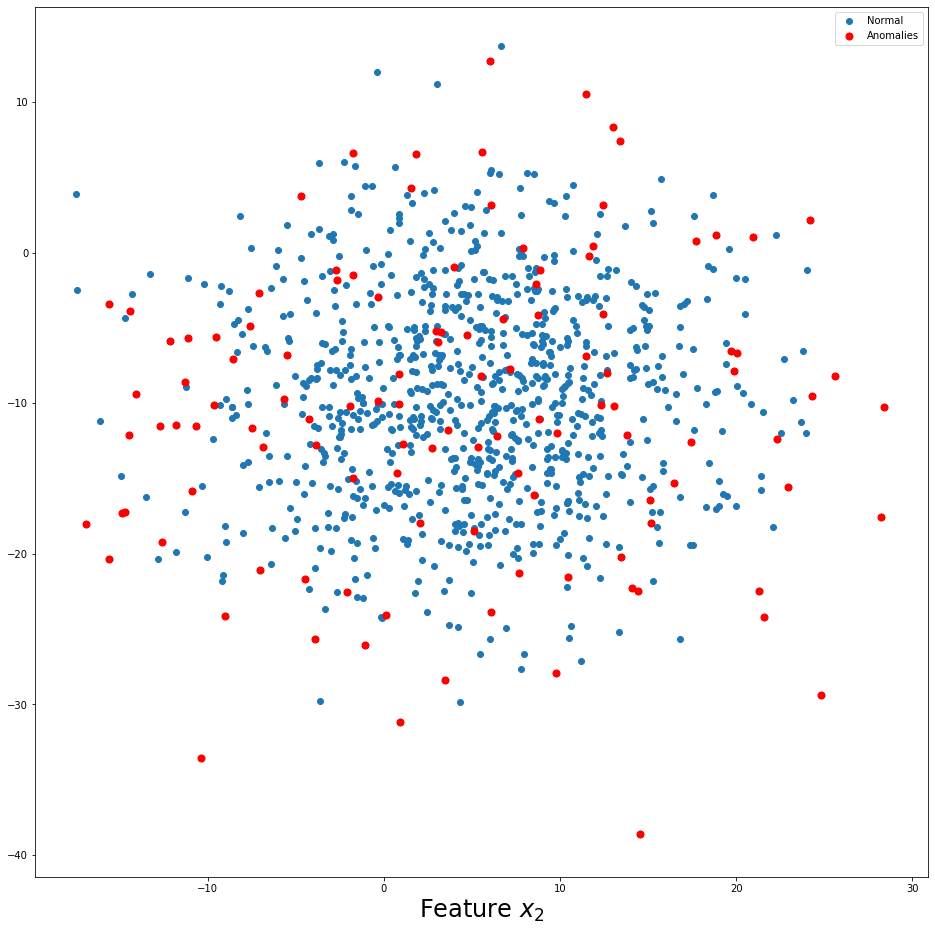

In [6]:
# Set the data path
dataDir = "./assignment/ex8/"
dataFile = "ex8data2.mat"
dataPath = dataDir+dataFile

# Load the data
data = loadmat(dataPath)
X = data['X']
XVal = data['Xval']
yVal = data['yval'].flatten()

# Get the Gaussian distribution and ideal threshold
mu,sigma2 = mean_and_var(X)
p = gaussian_distribution(X,mu,sigma2)
pVal = gaussian_distribution(XVal,mu,sigma2)
epsilon,F1 = select_threshold(pVal,yVal)

# Indexes of the values considered to be outlibers
outliers = np.where(p < epsilon)

# Create plot
fig, ax = plt.subplots(figsize=(16,16));
ax.scatter(X[:,0], X[:,1],label="Normal");
ax.scatter(X[outliers[0],0],X[outliers[0],1],s=50,color='r',label="Anomalies");
ax.set_xlabel("Feature $x_1$",fontsize=24);
ax.set_xlabel("Feature $x_2$",fontsize=24);
ax.legend();

Now the anomalies don't look as clearly anomalous in this 2D feature space, but given all of the 11 features, these 117 elements were found to be anomalous.

## Recommender Systems

Now we will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset is from the [MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research. The matrix

$$ Y \in  \mathbb{R}^{(n_m \times n_u} $$

stores the ratings from 1 to 5. The matrix 

$$ R \in  \mathbb{R}^{(n_m \times n_u} $$

is an binary-valued indicator matrix, where 

$$ R(i,j) = 1 $$

if user $j$ gave a rating to movie $i$, and 

$$ R(i,j) = 0 $$

otherwise. The objective of collaborative fltering is to predict movie ratings for the movies
that users have not yet rated, that is, the entries with 

$$ R(i,j) = 0.$$ 

This will allow us to recommend the movies with the highest predicted ratings to the user.

### Loading and Visualizing the Data

Let's first pull in the data and visualize it.

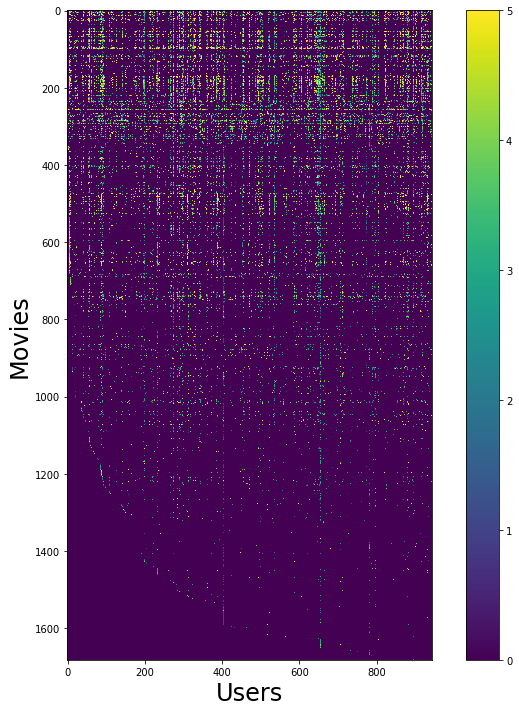

In [7]:
# Set the data path
dataDir = "./assignment/ex8/"
dataFile = "ex8_movies.mat"
dataPath = dataDir+dataFile

# Load the data
data = loadmat(dataPath)
Y = data['Y']
R = data['R']

# Plot the data
fig, ax = plt.subplots(figsize=(10,10))
image = ax.imshow(Y)
ax.set_xlabel('Users',fontsize=24)
ax.set_ylabel('Movies',fontsize=24)
cbar = plt.colorbar(image,ax=ax);
fig.tight_layout()

### Cost Function and Gradients

We need to create a function for the collaborative filtering cost function and gradients.  The cost function can be written as

$$ J(x^{(1)},\cdots,x^{(n_m)},\theta^{(1)},\cdots,\theta^{(n_u)} = 
   \frac{1}{2} \sum_{(i,j):r(i,j)=1} \Big( (\theta^{(j)})^T x^{(i)} - y^{(i,j)} \Big)^2 + \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \big( x_k^{(i)} \big)^2 + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n \big( \theta_k^{(j)} \big)^2 .$$

In [8]:
def cost(params,Y,R,nFeatures,regCoeff):
    
    # Recast Y and R as matrices
    Y = np.matrix(Y)
    R = np.matrix(R)

    # Get the number of users and movies
    nMovies = Y.shape[0]
    nUsers = Y.shape[1]

    # Reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:nMovies * nFeatures], (nMovies, nFeatures)))
    Theta = np.matrix(np.reshape(params[nMovies * nFeatures:], (nUsers, nFeatures)))

    # Initializations
    J = 0
    XGrad = np.zeros(X.shape)
    ThetaGrad = np.zeros(Theta.shape)

    # Compute the cost
    error = np.multiply((X*Theta.T)-Y,R)
    J = 0.5*np.sum(np.power(error,2))

    # Add the cost regularization
    J = J + ((regCoeff / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((regCoeff / 2) * np.sum(np.power(X, 2)))

    # calculate the gradients with regularization
    XGrad = (error * Theta) + (regCoeff * X)
    ThetaGrad = (error.T * X) + (regCoeff * Theta)

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(XGrad), np.ravel(ThetaGrad)))
    
    return J,grad


### Learning Movie Recommendations

Now let's see how our recommender system performs by minimizing the cost function. This time, we'll find our own parameters instead of using those provided to us. First, though, let's add ratings to a new user we've observed.

In [9]:
# Read movie ratings from file
movieInd = {}
f = open('assignment/ex8/movie_ids.txt')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movieInd[int(tokens[0]) - 1] = ' '.join(tokens[1:])

# Fill movie ratings with what we've "observed"
ratings = np.zeros((1682, 1))
ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

# Print table of ratings
for i in range(len(ratings)):
    if ratings[i] > 0:
        print('Rated %d stars: %s' % (ratings[i], movieInd[i]))


Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


Now let's add these ratings to the dataset and then train the collaborative filtering model to learn our parameters.

In [10]:
#  Load data
data = loadmat('assignment/ex8/ex8_movies.mat')
Y,R = data['Y'],data['R']

#  Add our own ratings to the data matrix
Y = np.append(Y,ratings,axis=1)
R = np.append(R,ratings!=0,axis=1)

# Set the parameters
nMovies = Y.shape[0]
nUsers = Y.shape[1]
nFeatures = 10
regCoeff = 10.

# Normalize the ratings
YMean = np.zeros((nMovies, 1))
YNormalized = np.zeros((nMovies, nUsers))
for i in range(nMovies):
    ind = np.where(R[i,:] == 1)[0]
    YMean[i] = Y[i,ind].mean()
    YNormalized[i,ind] = Y[i,ind] - YMean[i]

# Set initial parameters with randomization 
X = np.random.randn(nMovies, nFeatures)
Theta = np.random.randn(nUsers, nFeatures)

# Combine parameters
initialParameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 10
res = optimize.minimize(lambda x: cost(x,YNormalized,R,nFeatures,regCoeff),initialParameters,\
                        method='TNC',jac=True,options=options)
theta = res.x

# Unfold the returned theta back X and Theta
X = np.matrix(theta[:nMovies*nFeatures].reshape(nMovies, nFeatures))
Theta = np.matrix(theta[nMovies*nFeatures:].reshape(nUsers, nFeatures))

And now we can use those parameters to make predictions for ratings.

In [11]:
# Get the predicted ratings for the new user
p = X*Theta.T
predictions = p[:,-1] + YMean

# Read movie ratings from file
movieList = {}
f = open('assignment/ex8/movie_ids.txt')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movieList[int(tokens[0]) - 1] = ' '.join(tokens[1:])

# We lost the indexes for our predictions, so let's get them back
ind = np.argsort(predictions, axis=0)[::-1]

# Print results for predictions
print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ind[i,0]
    print('Predicting rating %.1f for movie %s' % (predictions[j].item(), movieList[j]))

# Print original ratings provided
print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(ratings)):
    if ratings[i] > 0:
        print('Rated %d for %s' % (ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Prefontaine (1997)

Original ratings provided:
--------------------------
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Si